In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!pip install torchaudio > .null.txt
!pip install PyDrive > .null.txt
!pip install soundfile > .null.txt

## Get the data

In [2]:
!git clone https://github.com/ogunlao/yoruba_speech_project.git ysp

Cloning into 'ysp'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 2394 (delta 13), reused 26 (delta 7), pack-reused 2361
Receiving objects: 100% (2394/2394), 288.13 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (1139/1139), done.
Checking out files: 100% (3012/3012), done.


## Get libraries and dependencies

In [3]:
!git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [4]:
%cd /content/CPC_audio
!python setup.py develop > .null.txt

/content/CPC_audio
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from cpc/eval/ABX/dtw.c:625:
/usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


## Getting data and language model

In [5]:
# !cp -R /content/gdrive/My\ Drive/speech_recognition/data.zip /content
# !unzip /content/data.zip -d /content/data > .null.txt

In [6]:
# !cp -R /content/gdrive/My\ Drive/speech_recognition/wiki_* /content

In [7]:
# get the code
!git clone --recursive https://github.com/parlance/ctcdecode.git
%cd ctcdecode

# install dependencies (PyTorch and CFFI)
!pip install -r requirements.txt

!python setup.py install > .null.txt
# If you do NOT require kenlm, the `--recursive` flag is not required on git clone
# and `--exclude-kenlm` should be appended to the `python setup.py install` command

Cloning into 'ctcdecode'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 979 (delta 3), reused 1 (delta 0), pack-reused 966
Receiving objects: 100% (979/979), 740.44 KiB | 6.73 MiB/s, done.
Resolving deltas: 100% (467/467), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/CPC_audio/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/CPC_audio/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 97, done.        
remote: Counting objects: 100% (97/97), done.        
remote: Compressing objects: 100% (80/80), done.        
remote: Total 13421 (delta

Warning: Restart runtime after the above installations and run the remaining steps below without installing again.

In [1]:
import torch
import torchaudio
from ctcdecode import CTCBeamDecoder
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Part 1 : contrastive predictive coding

Contrastive Predictive Coding (CPC) is a method of unsupervised training for speech models. The idea behind it is pretty simple:


1.   The raw audio wave is passed through a convolutional network: the ```encoder```
2.   Then, the encoder's output is given to a recurrent network the ```context```
3. A third party network, the ```prediction_network``` will try to predict the  future embeddings of the encoder using the output of the context network.

In order to avoid a collapse to trivial solutions, the prediction_network doesn't try to reconstruct the future features. Instead, using the context output $c_t$ at time $t$ it is trained to discriminate the real  encoder representatioin $g_{t+k}$ at time $t+k$ from several other features $(g_n)_n$ taken elsewhere in the batch. Thus the loss becomes:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \text{Cross_entropy}(\phi_k(c_t), g_{t+k}) \\]

Or:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \log \frac{ \exp\left(\phi_k(c_t)^\top g_{t+k}\right) }{  \sum_{\mathbf{n}\in\mathcal{N}_t} \exp\left(\phi_k(c_t)^\top g_n\right)} \\]

Where:


*   $\phi_k$ is the prediction network for the kth timestep
*   $\mathcal{N}_t$ is the set of all negative examples sampled for timestep $t$




## Exercice 1 : Building the model

In this exercise, we will build and train a small CPC model using the repository CPC_audio.

The code below loads a context and an encoder newtorks.

In [2]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DIM_ENCODER=256
DIM_CONTEXT=256
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128

/content/CPC_audio


In [3]:
encoder = CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, 1, mode=CONTEXT_RNN).to(device)

In [4]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

Now build a new class, ```CPCModel``` which will

In [5]:
class CPCModel(torch.nn.Module):

    def __init__(self,
                 encoder,
                 AR):

        super(CPCModel, self).__init__()
        self.gEncoder = encoder
        self.gAR = AR

    def forward(self, batch_data):

        encoder_output = self.gEncoder(batch_data)
        

        #print(encoder_output.shape)
        # The output of the encoder data does not have the good format 
        # indeed it is Batch_size x Hidden_size x temp size
        # while the context requires Batch_size  x temp size x Hidden_size
        # thus you need to permute
        context_input = encoder_output.permute(0, 2, 1)
        

        context_output = self.gAR(context_input)
        
        #print(context_output.shape)
        return context_output, encoder_output

Let's test your code !


In [6]:
DATA_PATH = "/content/ysp/data/"
audio = torchaudio.load("/content/ysp/data/records/train/200625-215447_yor_874_elicit_13.wav")[0]
audio = audio.view(1, 1, -1)
cpc_model = CPCModel(encoder, context).to(device)
context_output, encoder_output = cpc_model(audio.to(device))

# Part 2 : Fine tuning

In [7]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data > .null.txt
!ls checkpoint_data

mkdir: cannot create directory ‘checkpoint_data’: File exists
--2020-07-06 19:57:41--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt.2’

checkpoint_30.pt.2  100%[===================>] 108.34M  23.1MB/s    in 5.3s    

2020-07-06 19:57:47 (20.5 MB/s) - ‘checkpoint_data/checkpoint_30.pt.2’ saved [113599715/113599715]

--2020-07-06 19:57:48--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.f

Then we will use a simple linear classifier to recognize the phonemes from the features produced by ```cpc_model```. 

### a) Build the character classifier 

Design a class of linear classifiers, ```CharacterClassifier``` that will take as input a batch of sequences of CPC features and output a score vector for each phoneme

In [8]:
class CharacterClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_characters : int):
    super(CharacterClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_characters)
    

  def forward(self, x):
    return self.linear(x)

Our phone classifier will then be:

## Exercise 2 : Characters separability without alignment (CER)

Aligned data are very practical, but un real life they are rarely available. That's why in this excercise we will consider a fine-tuning with non-aligned phonemes.

The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

In [9]:
loss_ctc = torch.nn.CTCLoss()

Besides, we will use a siglthy different dataset class.

### a- Training

Since the phonemes are not aligned, there is no simple direct way to get the classification acuracy of a model. Write and test the three functions ```train_one_epoch_ctc```, ```validation_step_ctc``` and ```run_ctc``` as before but without considering the average acuracy of the model. 

In [10]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  per_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,cpc_model,character_classifier)
    per_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, per_val

def save_checkpoint(model,classifier,path="/content/checkpoint.ckpt"):
  torch.save(model.state_dict(), path)
  torch.save(classifier.state_dict(), path+".classifier")


def load_checkpoint(model,classifier,path="/content/checkpoint.ckpt"):
  model.load_state_dict(torch.load(path))
  classifier.load_state_dict(torch.load(path+".classifier"))

### b- Evaluation: the Character Error Rate (CER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Character Error Rate (CER).

This value can be interpreted as :
\\[  CER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [11]:
import numpy as np

def get_CER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1, m+1))
  for i in range(1, n+1):
    D[i,0] = D[i-1, 0]+1
  for j in range(1, m+1):
    D[0,j] = D[0, j-1]+1
  
  ### TODO compute the alignment

  for i in range(1, n+1):
    for j in range(1, m+1):
      D[i,j] = min(
          D[i-1, j]+1,
          D[i-1, j-1]+1,
          D[i, j-1]+1,
          D[i-1, j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

You can test your function below:

In [12]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_CER = 4. / 7.
print(get_CER_sequence(ref_seq, pred_seq) == expected_CER)

True


### c- Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [13]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_cer(test_dataloader,
            cpc_model,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=20,cutoff_top_n=20) #model_path="/content/wiki_00.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          # print(sizePhone[b], out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


In [14]:
with open("/content/ysp/data/charset.txt") as js:
  characters = eval(js.read())

In [15]:
chars = [0]*len(characters)
for k,v in characters.items():
  chars[v]=k
print(chars)
# chars[1] = '$'

['ε', ' ', 's', 'g', 'p', 'ò', 'v', 'é', 'k', 'e', 'ọ', 'ṣ', 'd', 'è', 'i', 'í', 'ẹ', 'ú', 'ù', 'r', 'l', 'j', 'ì', 'á', 'y', 't', 'n', 'a', 'à', 'b', 'o', 'h', 'w', 'ó', 'f', 'u', 'm', 'c', '–', 'ń', 'ǹ', 'z', 'ḿ', 'ί', 'ὸ']


In [16]:
len(chars)

45

In [17]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = '/content/ysp/data/records/train/'
path_val_data_cer = '/content/ysp/data/records/val'
path_letter_data_cer = '/content/ysp/data/chars.txt'
BATCH_SIZE=2

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
N_LETTERS=len(chars) # for the blank token
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)
path_letter_data_cer

# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
torch.manual_seed(0)
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=False)

1it [00:00, 226.94it/s]

/content/CPC_audio
Saved cache file at /content/ysp/data/records/train/_seqs_cache.txt



1it [00:00, 252.46it/s]

Loaded 281 sequences in 1.87 seconds
maxSizeSeq : 321981
maxSizePhone : 118
minSizePhone : 2
Total size dataset 0.8402519965277778 hours
Saved cache file at /content/ysp/data/records/val/_seqs_cache.txt


Loaded 71 sequences in 1.28 seconds
maxSizeSeq : 291852
maxSizePhone : 103
minSizePhone : 5
Total size dataset 0.19658164930555555 hours


In [18]:
path_test_data_cer = '/content/ysp/data/records/test/'
data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)
data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=False)

1it [00:00, 269.80it/s]

Saved cache file at /content/ysp/data/records/test/_seqs_cache.txt


Loaded 351 sequences in 2.28 seconds
maxSizeSeq : 450120
maxSizePhone : 128
minSizePhone : 2
Total size dataset 1.0097087152777777 hours


In [19]:
from cpc.feature_loader import loadModel
torch.manual_seed(0)

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = CharacterClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [20]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)
lr_sch_frozen = ReduceLROnPlateau(optimizer_frozen,factor=0.2,patience=5,verbose=True)


In [21]:
loss_ctc = torch.nn.CTCLoss()

In [22]:
torch.manual_seed(0)
losses_train, losses_val, cer_val = run_ctc(
    cpc_model,
    character_classifier,
    loss_ctc,
    data_loader_train_letters,
    data_loader_val_letters,
    optimizer, lr_sch,n_epoch=80)

Running epoch 1 / 80


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


-------------------
Training dataset :
Average loss : 23.088451186248236.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9780895487007106
Average loss : 4.166263410023281
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 3.7125847663198197.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9894249582260844
Average loss : 3.4327618053981235
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 3.4200978466442655.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9895073758085021
Average loss : 3.3358032158442907
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 3.348144897392818.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9859810754348761
Average loss : 3.2843833446502684
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.3171691843441553.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9891935842555577
Average loss : 3.2609021868024555
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.289646361555372.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9852723129007345
Average loss : 3.2477181434631346
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.2899744749069213.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9865020793142857
Average loss : 3.2581048420497347
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.2575421946389334.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9861962753147332
Average loss : 3.2297737666538784
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.236425084727151.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9793426332971815
Average loss : 3.2237405981336322
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.229001251288823.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9827458087133044
Average loss : 3.220290115901402
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.226537959916251.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9664692241340469
Average loss : 3.2158223015921457
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.2211184774126327.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9806381877519976
Average loss : 3.2134623118809293
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.2157300114631653.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.979541598806121
Average loss : 3.2087461812155587
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.2137608085359846.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9808106316155057
Average loss : 3.2056117125919887
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.2079346231051855.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9655580660386544
Average loss : 3.208488995688302
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.20025623014995.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9766654890134071
Average loss : 3.195744718824114
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.2012129868779864.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9768422111295205
Average loss : 3.194729334967477
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.1854807904788425.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.994224393941034
Average loss : 3.18549679347447
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.1724072320120675.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9927152402888948
Average loss : 3.173597744532994
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.160697754791805.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9899802298279357
Average loss : 3.1631282261439733
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.157754078933171.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9847580316942459
Average loss : 3.16258031300136
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.1501325828688485.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9727364931004553
Average loss : 3.155091803414481
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.1499287366867064.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9873708469902576
Average loss : 3.135387338910784
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 3.118154534271785.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.976540948090926
Average loss : 3.1103817394801547
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 3.0921844158853804.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.974777492166351
Average loss : 3.0848347187042235
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 3.0581105555806842.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9799199066238578
Average loss : 3.056258882795061
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 3.0049139363425117.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9385287047305503
Average loss : 2.9848573071616036
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 2.9397042172295706.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9281192935045143
Average loss : 2.9201155935014995
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 2.8673305443355015.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9149394763390425
Average loss : 2.8400340284620014
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 2.7988366041864667.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9095299383244116
Average loss : 2.762750904900687
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 2.7206301723207744.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.8607371177596604
Average loss : 2.685194982801165
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 2.626962789467403.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.8440859613073436
Average loss : 2.5821990966796875
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 2.520181165422712.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.8041102228174557
Average loss : 2.4761384691510884
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 2.401744534288134.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.7949811751959227
Average loss : 2.3596097946166994
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 2.2803195101874216.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.7441077099931822
Average loss : 2.238481068611145
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 2.162517328773226.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.7691202772216049
Average loss : 2.1458250420434135
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 2.0477480837277002.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.6784880707433478
Average loss : 2.0124688148498535
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 1.937054750749043.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.6634639290997044
Average loss : 1.9543159348624093
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 1.860265495095934.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.6044614507796856
Average loss : 1.854394725390843
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 1.7384655450071607.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.5795957056964646
Average loss : 1.7936457702091761
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 1.666231370823724.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Average CER 0.5323971397741408
Average loss : 1.714483720915658
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 1.5893654874392917.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Average CER 0.5354864074827036
Average loss : 1.639080160004752
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 1.5036767938307354.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Average CER 0.5099861217764333
Average loss : 1.5793894938060216
-------------------

Running epoch 44 / 80
-------------------
Training dataset :
Average loss : 1.466055001957076.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Average CER 0.5094047011168883
Average loss : 1.581663921901158
-------------------

Running epoch 45 / 80
-------------------
Training dataset :
Average loss : 1.4199484995433262.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.48686357789722173
Average loss : 1.6467731305531093
-------------------

Running epoch 46 / 80
-------------------
Training dataset :
Average loss : 1.399318596294948.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.46070376954462416
Average loss : 1.506050365311759
-------------------

Running epoch 47 / 80
-------------------
Training dataset :
Average loss : 1.3039907123361314.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.43020314137536575
Average loss : 1.4568699768611364
-------------------

Running epoch 48 / 80
-------------------
Training dataset :
Average loss : 1.3099211756672178.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.46208414230671285
Average loss : 1.4998125519071306
-------------------

Running epoch 49 / 80
-------------------
Training dataset :
Average loss : 1.245537497316088.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.42066043984716395
Average loss : 1.3941047242709568
-------------------

Running epoch 50 / 80
-------------------
Training dataset :
Average loss : 1.1977122707026346.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.4076588682657089
Average loss : 1.3644436546734402
-------------------

Running epoch 51 / 80
-------------------
Training dataset :
Average loss : 1.1588752989258084.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.4092403537601122
Average loss : 1.3805656007358007
-------------------

Running epoch 52 / 80
-------------------
Training dataset :
Average loss : 1.135106179543904.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.41081731359001505
Average loss : 1.3439519950321743
-------------------

Running epoch 53 / 80
-------------------
Training dataset :
Average loss : 1.1048366052763803.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3996455635497472
Average loss : 1.3389367393084934
-------------------

Running epoch 54 / 80
-------------------
Training dataset :
Average loss : 1.081296008825302.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.38931997230165044
Average loss : 1.3506046737943376
-------------------

Running epoch 55 / 80
-------------------
Training dataset :
Average loss : 1.0532645057354655.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.3829865975099681
Average loss : 1.2803181971822466
-------------------

Running epoch 56 / 80
-------------------
Training dataset :
Average loss : 1.0173471846750803.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.36450772873061177
Average loss : 1.2746706690107072
-------------------

Running epoch 57 / 80
-------------------
Training dataset :
Average loss : 1.0082261164273534.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3618844206890512
Average loss : 1.2579772881099156
-------------------

Running epoch 58 / 80
-------------------
Training dataset :
Average loss : 0.9700722979647772.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3612216582071684
Average loss : 1.277223151070731
-------------------

Running epoch 59 / 80
-------------------
Training dataset :
Average loss : 0.9344643247979028.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.3739673460203875
Average loss : 1.258746199948447
-------------------

Running epoch 60 / 80
-------------------
Training dataset :
Average loss : 0.9046175929052489.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.38964250450816085
Average loss : 1.292268191065107
-------------------

Running epoch 61 / 80
-------------------
Training dataset :
Average loss : 0.9155850844723837.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.36320001913852584
Average loss : 1.242203220299312
-------------------

Running epoch 62 / 80
-------------------
Training dataset :
Average loss : 0.8753548807331494.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.35440979021144486
Average loss : 1.2298447234289986
-------------------

Running epoch 63 / 80
-------------------
Training dataset :
Average loss : 0.8648267613989966.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.35417359664346665
Average loss : 1.2796051127570016
-------------------

Running epoch 64 / 80
-------------------
Training dataset :
Average loss : 0.8586251810193062.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3443965630494995
Average loss : 1.2057083555630275
-------------------

Running epoch 65 / 80
-------------------
Training dataset :
Average loss : 0.8339054490838732.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.32140678672554623
Average loss : 1.1951245955058507
-------------------

Running epoch 66 / 80
-------------------
Training dataset :
Average loss : 0.7817578083170312.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.34481580320600863
Average loss : 1.2368258595466615
-------------------

Running epoch 67 / 80
-------------------
Training dataset :
Average loss : 0.7655124244945389.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.3438938492923464
Average loss : 1.2073234268597195
-------------------

Running epoch 68 / 80
-------------------
Training dataset :
Average loss : 0.7579833403229713.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.33759305476474194
Average loss : 1.2052714262689863
-------------------

Running epoch 69 / 80
-------------------
Training dataset :
Average loss : 0.7174078266535486.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.3357406551088791
Average loss : 1.2001669372831072
-------------------

Running epoch 70 / 80
-------------------
Training dataset :
Average loss : 0.7271910350237574.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.3487322155977803
Average loss : 1.2502359577587672
-------------------

Running epoch 71 / 80
-------------------
Training dataset :
Average loss : 0.7071984825389726.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    71: reducing learning rate of group 0 to 4.0000e-05.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3455530125782362
Average loss : 1.221691724232265
-------------------

Running epoch 72 / 80
-------------------
Training dataset :
Average loss : 0.6063650975269931.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.32140043131776597
Average loss : 1.1540305273873466
-------------------

Running epoch 73 / 80
-------------------
Training dataset :
Average loss : 0.5557614226426397.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.3155645491140072
Average loss : 1.1527485030038016
-------------------

Running epoch 74 / 80
-------------------
Training dataset :
Average loss : 0.534320290173803.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.30604781490796124
Average loss : 1.1502565554210118
-------------------

Running epoch 75 / 80
-------------------
Training dataset :
Average loss : 0.5199052748935563.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.31098799128371735
Average loss : 1.1542058961732047
-------------------

Running epoch 76 / 80
-------------------
Training dataset :
Average loss : 0.505505782259362.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.31664919568948824
Average loss : 1.1505545820508685
-------------------

Running epoch 77 / 80
-------------------
Training dataset :
Average loss : 0.49502518182354316.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.30936593656794836
Average loss : 1.1560552188328335
-------------------

Running epoch 78 / 80
-------------------
Training dataset :
Average loss : 0.4842639889035906.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.3104527303983481
Average loss : 1.154986310005188
-------------------

Running epoch 79 / 80
-------------------
Training dataset :
Average loss : 0.4718918654535498.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.30404318371164396
Average loss : 1.1640853915895735
-------------------

Running epoch 80 / 80
-------------------
Training dataset :
Average loss : 0.4673136156052351.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    80: reducing learning rate of group 0 to 8.0000e-06.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average CER 0.30659384340213164
Average loss : 1.1637145263808115
-------------------

loading best model with CER  0.30404318371164396


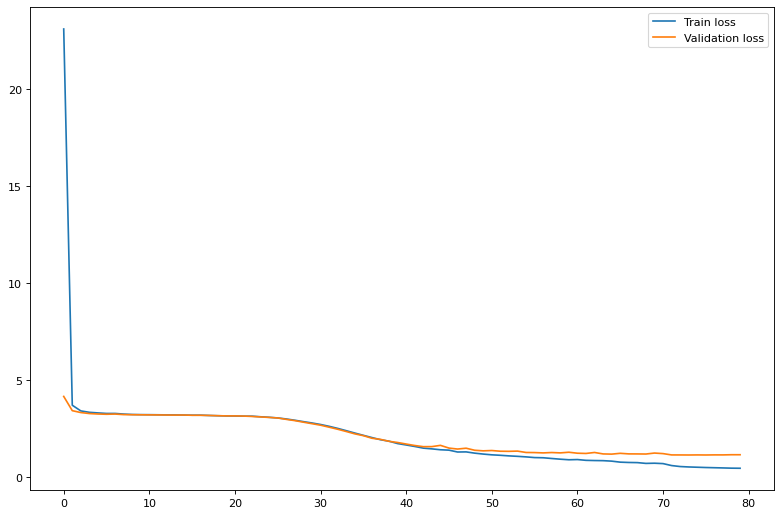

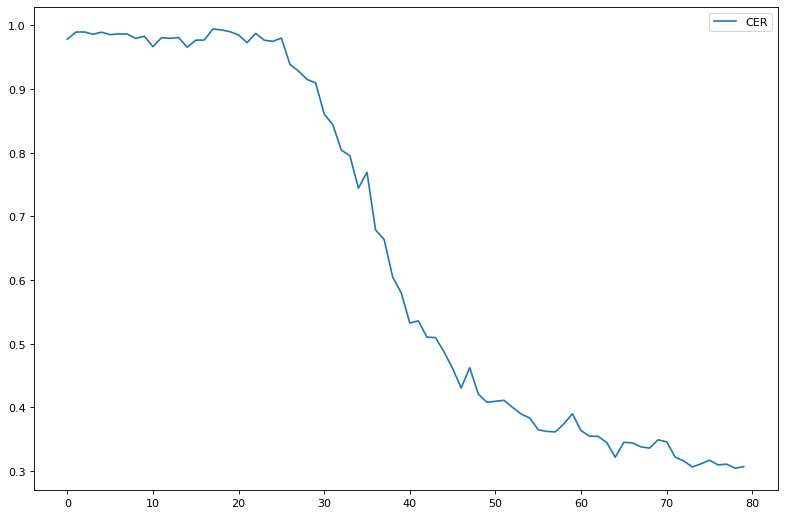

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")


In [26]:
 get_cer(data_loader_test_letters, cpc_model,character_classifier)

N/A% (0 of 175) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (175 of 175) |######################| Elapsed Time: 0:01:37 Time:  0:01:37


Average CER 0.34755710537860496


0.34755710537860496

# Part 3 : Characters recognition without pre-training

Let's estimate the impact of the pre-training by estimating the CER of a model trained from scratch on the labelled dataset.

In [21]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)


    bs=x.size(0)
    optimizer.zero_grad()


    context_out, enc_out = cpc_model(x.to(device))

    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)

    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out = cpc_model(x.to(device))
    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  cer_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,cpc_model,character_classifier)
    cer_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, cer_val



In [22]:
import progressbar
from multiprocessing import Pool


def get_cer(test_dataloader,
            cpc_model,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature, _= cpc_model(seq.to(device))
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=40,cutoff_top_n=40) #,model_path="/content/wiki_00.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          #print(sizePhone[b],out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


## Exercice 1: training from scratch on the labelled dataset

What kind of performance will you get if you try to launch the fine-tuning without pre-training ? Check out the PER and the CER of ```cpc_non_pre_trained``` below.

In [23]:
torch.manual_seed(0)
encoder =  CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, N_LEVELS_CONTEXT, mode=CONTEXT_RNN).to(device)
cpc_non_pre_trained = CPCModel(encoder, context).to(device)

In [24]:
torch.manual_seed(0)

character_classifier = CharacterClassifier(DIM_CONTEXT, N_LETTERS).to(device)
parameters = list(character_classifier.parameters()) + list(cpc_non_pre_trained.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)


In [25]:
loss_ctc = torch.nn.CTCLoss()

In [26]:
losses_train, losses_val, cer_val = run_ctc(cpc_non_pre_trained,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer,lr_sch,n_epoch=80)

Running epoch 1 / 80


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


-------------------
Training dataset :
Average loss : 19.087395441532134.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9927624561036538
Average loss : 3.5650069917951313
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 3.4127739940370834.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9993947425123896
Average loss : 3.268037033081055
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 3.31858788899013.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9871879761073599
Average loss : 3.252269915172032
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 3.3112532888139996.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9563315412184017
Average loss : 3.247791916983468
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.3023413981710164.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9434358389350355
Average loss : 3.2468800749097553
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.300745757988521.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9488468103922653
Average loss : 3.241173117501395
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.3006728410720827.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9512555238223444
Average loss : 3.242990153176444
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.2985052841050284.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9366362828353967
Average loss : 3.2421654905591692
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.292148566246033.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.9718176437098348
Average loss : 3.261947052819388
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.295257207325527.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.9590788638548832
Average loss : 3.2436853408813477
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.2901630912508284.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.935028314034388
Average loss : 3.243869652066912
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.293424688066755.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    12: reducing learning rate of group 0 to 4.0000e-05.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9545500115306408
Average loss : 3.242693587711879
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.2839777656963896.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.943441855581713
Average loss : 3.239917768750872
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.2830082757132395.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9596481226740122
Average loss : 3.2408318928309847
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.2813774364335195.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.9617776179503839
Average loss : 3.239713362285069
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.281661774430956.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9675306080763976
Average loss : 3.2416676793779646
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.2790859409740993.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9532300234872246
Average loss : 3.235666288648333
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.275530345099313.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9622544308386446
Average loss : 3.238325125830514
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.270356845855713.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9560292518331538
Average loss : 3.2325762816837855
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.2652804613113404.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9532321939345602
Average loss : 3.2287178788866315
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.256174327645983.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.9387925464512321
Average loss : 3.2262843063899447
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.2485952922276087.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9561248831229279
Average loss : 3.2207459041050504
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.2437653575624736.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.960671248207282
Average loss : 3.223336853299822
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 3.238404623099736.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9491639534563289
Average loss : 3.216622202736991
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 3.238292178085872.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9431930406810043
Average loss : 3.2168265887669154
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 3.2328908579690117.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9511264851329646
Average loss : 3.216594226019723
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 3.2279535821505956.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9383572936360121
Average loss : 3.2121963364737374
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 3.2257421561649866.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9439819144536634
Average loss : 3.212067563193185
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 3.2231207609176638.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9391445223675218
Average loss : 3.213915538787842
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 3.2207347631454466.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9625867946709978
Average loss : 3.2273153918130055
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 3.2163718138422284.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9408008763643922
Average loss : 3.2092071192605154
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 3.2121870824268886.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9420736227145438
Average loss : 3.2130604335239954
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 3.2087137716157095.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9415961401042493
Average loss : 3.206812565667289
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 3.2070623295647755.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9392511679669933
Average loss : 3.208570214680263
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 3.2008526171956744.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9197753808955107
Average loss : 3.2054551328931535
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 3.1996166689055308.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9369062651252422
Average loss : 3.2059274537222726
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 3.1974058423723495.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9193581642134475
Average loss : 3.203425325666155
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 3.198110268797193.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9373647235894412
Average loss : 3.2035351072038925
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 3.1900229334831236.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9167623649552171
Average loss : 3.198502819878714
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 3.18987341097423.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9394041901731528
Average loss : 3.1955561910356796
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 3.181805099759783.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.919827118861518
Average loss : 3.1921671731131416
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 3.177276034014566.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9400868366255882
Average loss : 3.18727263041905
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 3.17317145722253.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.9203087987869841
Average loss : 3.177117415836879
-------------------

Running epoch 44 / 80
-------------------
Training dataset :
Average loss : 3.1681348255702426.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Average CER 0.938507313290337
Average loss : 3.1749115398951937
-------------------

Running epoch 45 / 80
-------------------
Training dataset :
Average loss : 3.1589922070503236.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9296548571332585
Average loss : 3.1660568509783062
-------------------

Running epoch 46 / 80
-------------------
Training dataset :
Average loss : 3.146906888484955.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9150943932172869
Average loss : 3.1457041263580323
-------------------

Running epoch 47 / 80
-------------------
Training dataset :
Average loss : 3.130534907749721.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9562334897552278
Average loss : 3.1510199887411936
-------------------

Running epoch 48 / 80
-------------------
Training dataset :
Average loss : 3.10323851449149.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.8780764369326705
Average loss : 3.1056073188781737
-------------------

Running epoch 49 / 80
-------------------
Training dataset :
Average loss : 3.070740381308964.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.9134518690952165
Average loss : 3.069408770969936
-------------------

Running epoch 50 / 80
-------------------
Training dataset :
Average loss : 3.034222183908735.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.8738599029839538
Average loss : 3.0372560024261475
-------------------

Running epoch 51 / 80
-------------------
Training dataset :
Average loss : 2.992114164148058.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.8899626239894616
Average loss : 2.9945804527827673
-------------------

Running epoch 52 / 80
-------------------
Training dataset :
Average loss : 2.9455701521464754.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.9012472047721337
Average loss : 2.969737379891532
-------------------

Running epoch 53 / 80
-------------------
Training dataset :
Average loss : 2.905598769869123.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.8441781049816885
Average loss : 2.8983167580195834
-------------------

Running epoch 54 / 80
-------------------
Training dataset :
Average loss : 2.8576491934912545.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.8491752924758701
Average loss : 2.8587927341461183
-------------------

Running epoch 55 / 80
-------------------
Training dataset :
Average loss : 2.802840152808598.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.8365500719389455
Average loss : 2.8103679725102015
-------------------

Running epoch 56 / 80
-------------------
Training dataset :
Average loss : 2.757127228804997.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.8480214456058469
Average loss : 2.7818002155848913
-------------------

Running epoch 57 / 80
-------------------
Training dataset :
Average loss : 2.7065974490983145.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.8515402997010324
Average loss : 2.709327874864851
-------------------

Running epoch 58 / 80
-------------------
Training dataset :
Average loss : 2.655502808094025.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.8223241385729521
Average loss : 2.6716729300362725
-------------------

Running epoch 59 / 80
-------------------
Training dataset :
Average loss : 2.6057419674737115.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.8180994640085111
Average loss : 2.615891817637852
-------------------

Running epoch 60 / 80
-------------------
Training dataset :
Average loss : 2.552371520655496.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.7777393396209213
Average loss : 2.60363358770098
-------------------

Running epoch 61 / 80
-------------------
Training dataset :
Average loss : 2.5053296753338405.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.7764259611269527
Average loss : 2.5508066177368165
-------------------

Running epoch 62 / 80
-------------------
Training dataset :
Average loss : 2.469668345791953.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.7978731125440623
Average loss : 2.5090888636452813
-------------------

Running epoch 63 / 80
-------------------
Training dataset :
Average loss : 2.425826173169272.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.7603104965751187
Average loss : 2.4644259520939418
-------------------

Running epoch 64 / 80
-------------------
Training dataset :
Average loss : 2.3822174174445014.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.7555206067516571
Average loss : 2.440520375115531
-------------------

Running epoch 65 / 80
-------------------
Training dataset :
Average loss : 2.3479666028703963.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


Average CER 0.7412066917285228
Average loss : 2.423350143432617
-------------------

Running epoch 66 / 80
-------------------
Training dataset :
Average loss : 2.3140101109232223.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.7568479096879237
Average loss : 2.3734198093414305
-------------------

Running epoch 67 / 80
-------------------
Training dataset :
Average loss : 2.2753807587283.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.7242328601675238
Average loss : 2.345525802884783
-------------------

Running epoch 68 / 80
-------------------
Training dataset :
Average loss : 2.2262925624847414.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


Average CER 0.7231832944498091
Average loss : 2.311622599193028
-------------------

Running epoch 69 / 80
-------------------
Training dataset :
Average loss : 2.202377530506679.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.6985674271671999
Average loss : 2.2715148142405917
-------------------

Running epoch 70 / 80
-------------------
Training dataset :
Average loss : 2.1644303841250285.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


Average CER 0.7088113086494561
Average loss : 2.2508559329169135
-------------------

Running epoch 71 / 80
-------------------
Training dataset :
Average loss : 2.140058186224529.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.6904347785165624
Average loss : 2.231792518070766
-------------------

Running epoch 72 / 80
-------------------
Training dataset :
Average loss : 2.097678358214242.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


Average CER 0.7018620108858368
Average loss : 2.2095058304922923
-------------------

Running epoch 73 / 80
-------------------
Training dataset :
Average loss : 2.07270718727793.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.6943087852211847
Average loss : 2.192728434290205
-------------------

Running epoch 74 / 80
-------------------
Training dataset :
Average loss : 2.0406900422913687.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.6660056218660401
Average loss : 2.163150177683149
-------------------

Running epoch 75 / 80
-------------------
Training dataset :
Average loss : 2.0109224804810117.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.6777572877181492
Average loss : 2.179089205605643
-------------------

Running epoch 76 / 80
-------------------
Training dataset :
Average loss : 1.9882036055837358.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


Average CER 0.6414914129748185
Average loss : 2.12633615561894
-------------------

Running epoch 77 / 80
-------------------
Training dataset :
Average loss : 1.9587165585586004.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


Average CER 0.6503081835586547
Average loss : 2.106093270438058
-------------------

Running epoch 78 / 80
-------------------
Training dataset :
Average loss : 1.9254139065742493.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.6508443430174101
Average loss : 2.0678898402622767
-------------------

Running epoch 79 / 80
-------------------
Training dataset :
Average loss : 1.9015313242162977.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


Average CER 0.617729810125374
Average loss : 2.0696073974881855
-------------------

Running epoch 80 / 80
-------------------
Training dataset :
Average loss : 1.8845093667507171.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


Average CER 0.6052785986958922
Average loss : 2.044439138684954
-------------------

loading best model with CER  0.6052785986958922


In [27]:
get_cer(data_loader_test_letters,cpc_non_pre_trained,character_classifier)

N/A% (0 of 175) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (175 of 175) |######################| Elapsed Time: 0:02:13 Time:  0:02:13


Average CER 0.6258037931276315


0.6258037931276315

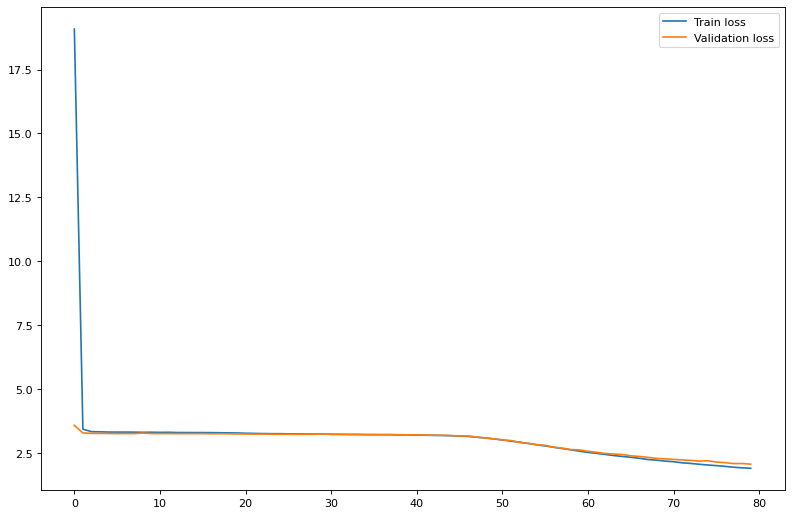

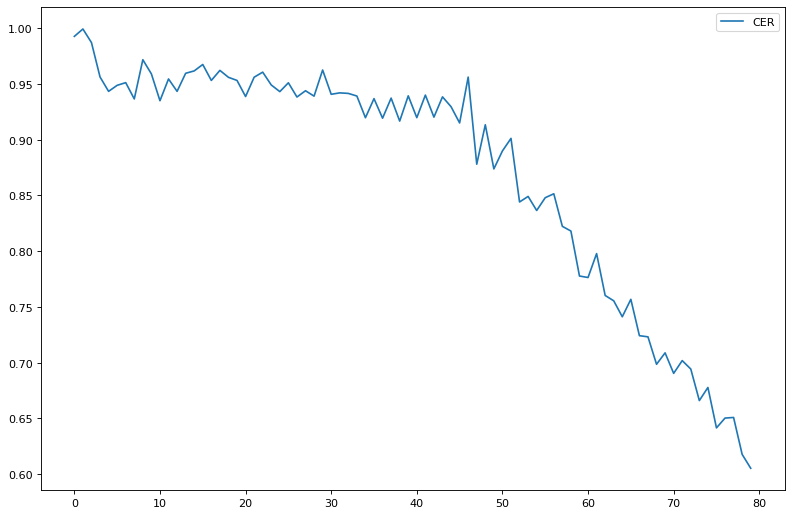

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")


## Exercice 2: Comparison with hand-crafted ASR features

Now replace train a character classifier on top of MFCC features. What CER do you get ?

See [here](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MFCC) to build MFCC features.

In [ ]:
mfcc_crafter = torchaudio.transforms.MFCC(n_mfcc=80)

In [ ]:
import torch.nn.functional as F

def train_one_epoch_ctc(character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    y = y.to(device)


    bs=x.size(0)
    optimizer.zero_grad()


    #context_out, enc_out = cpc_model(x.to(device))
    context_out = mfcc_crafter(x)
    context_out = context_out.to(device)
    context_out = context_out.squeeze(1)
    context_out = context_out.permute(0,2,1)
    #print("context_out.shape",context_out.shape)

    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)

    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      y =  y.to(device)

      bs=x.size(0)
      #context_out, enc_out = cpc_model(x.to(device))
      context_out = mfcc_crafter(x)
      #print("context_out.shape",context_out.shape)
      context_out = context_out.to(device)
      context_out = context_out.squeeze(1)
      context_out = context_out.permute(0,2,1)    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  cer_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,character_classifier)
    cer_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, cer_val



In [ ]:
import progressbar
from multiprocessing import Pool


def get_cer(test_dataloader,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature = mfcc_crafter(seq.cpu())
        c_feature = c_feature.to(device)
        c_feature = c_feature.squeeze(1)
        c_feature = c_feature.permute(0,2,1)
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=40,cutoff_top_n=40,model_path="/content/wiki_00.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          #print(sizePhone[b],out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


In [ ]:
character_classifier = CharacterClassifier(80, N_LETTERS).to(device)
torch.manual_seed(0)

parameters = character_classifier.parameters()
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)


In [ ]:
losses_train, losses_val, cer_val = run_ctc(character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer,lr_sch,n_epoch=80)

Running epoch 1 / 80
-------------------
Training dataset :
Average loss : 14.751724039325277.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:13 Time:  0:01:13


Average PER 0.8390506700817387
Average loss : 8.504963767771818
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 6.691724257918108.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:11 Time:  0:01:11


Average PER 0.7657650516839577
Average loss : 5.36388450739335
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 4.741111005535562.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:07 Time:  0:01:07


Average PER 0.7572868604321599
Average loss : 4.294742540437348
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 4.135660673825796.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:26 Time:  0:01:26


Average PER 0.7737702119854668
Average loss : 4.186240342198586
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.997281394235354.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:24 Time:  0:01:24


Average PER 0.760206625486238
Average loss : 3.980999990385406
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.959689742129571.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:02 Time:  0:01:02


Average PER 0.781727260379705
Average loss : 3.9187470114960963
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.8921875789875293.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:04 Time:  0:01:04


Average PER 0.7885607027446948
Average loss : 3.8318573455421294
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.8865963648293764.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:16 Time:  0:01:16


Average PER 0.8068313852014161
Average loss : 3.9221557354440493
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.82839786369382.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.806888462647973
Average loss : 3.81952225432104
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.781411860735362.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.8375079641546863
Average loss : 3.8398770799442214
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.7575083555459368.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.8324699455640877
Average loss : 3.832656446768313
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.7372495745884553.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:55 Time:  0:00:55


Average PER 0.8230530079583347
Average loss : 3.763090659161003
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.7382870181522905.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


Average PER 0.7499062340377952
Average loss : 3.7659226437004243
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.7049291722343773.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8352406047948324
Average loss : 3.9405543025659053
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.687989575262288.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:52 Time:  0:00:52


Average PER 0.8424113903036513
Average loss : 3.8485115936824252
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.7182703746184136.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:53 Time:  0:00:53


Average PER 0.8332103220821574
Average loss : 3.801217098625339
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.7117748272631306.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.7944808493934123
Average loss : 3.7387642714442038
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.696977315058235.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:56 Time:  0:00:56


Average PER 0.8048009755913269
Average loss : 3.8065284855511723
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.728127849617684.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8223054623111992
Average loss : 3.7243351644399216
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.702465736229001.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8168843209097959
Average loss : 3.7703750814710344
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.708560973936668.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:44 Time:  0:00:44


Average PER 0.841097084811886
Average loss : 3.895431659659561
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.70275513452428.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:45 Time:  0:00:45


Average PER 0.8329181472817969
Average loss : 3.8711295857721444
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.674356526090899.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8235607390324293
Average loss : 3.749088209502551
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 3.6525592676555836.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8384732583733003
Average loss : 3.863309081719846
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 3.669807880586037.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    25: reducing learning rate of group 0 to 2.0000e-04.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8149168383411293
Average loss : 3.73426907889697
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 3.561784005953762.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8106630073143422
Average loss : 3.695334264210292
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 3.5621941447561327.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.7812837024480325
Average loss : 3.695034815340626
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 3.552366776017439.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8131340944103168
Average loss : 3.6987548701617183
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 3.558631740453589.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8079171274339355
Average loss : 3.6774789605821883
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 3.54898564688122.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.781185907773097
Average loss : 3.7003912098553715
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 3.551024154245702.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8227109652205562
Average loss : 3.6826385867838956
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 3.5569422008427045.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.81455560369967
Average loss : 3.6778607027871266
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 3.55246086703002.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8068906641772273
Average loss : 3.677312335189508
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 3.550132932857096.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8289309140491516
Average loss : 3.710183673975419
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 3.55128842819738.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    35: reducing learning rate of group 0 to 4.0000e-05.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8038470715841144
Average loss : 3.678235808197333
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 3.528353746307412.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8098258601200616
Average loss : 3.6717075620378767
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 3.523666632994441.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8164703837199323
Average loss : 3.6787517995250467
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 3.51395558097587.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.813343358807571
Average loss : 3.672595535005842
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 3.5240296729041725.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8053368191531358
Average loss : 3.6728606661971734
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 3.5226182967955224.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8152489476495431
Average loss : 3.6792584584683787
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 3.52745342921968.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8075836483435418
Average loss : 3.6720701139800402
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 3.5225234225809423.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8027028748236278
Average loss : 3.670502487494021
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 3.527396695911126.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8041581922098027
Average loss : 3.668104721575367
-------------------

Running epoch 44 / 80
-------------------
Training dataset :
Average loss : 3.5247274901120718.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8074058934498693
Average loss : 3.6722177340059865
-------------------

Running epoch 45 / 80
-------------------
Training dataset :
Average loss : 3.5242445311170196.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8218346320142379
Average loss : 3.677501931482432
-------------------

Running epoch 46 / 80
-------------------
Training dataset :
Average loss : 3.522743852387251.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8228273837442107
Average loss : 3.6799447682439066
-------------------

Running epoch 47 / 80
-------------------
Training dataset :
Average loss : 3.533651650406932.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8191996409650845
Average loss : 3.67479031426566
-------------------

Running epoch 48 / 80
-------------------
Training dataset :
Average loss : 3.5202110790417698.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8200275757147051
Average loss : 3.6725326849489797
-------------------

Running epoch 49 / 80
-------------------
Training dataset :
Average loss : 3.5290003793536857.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    49: reducing learning rate of group 0 to 8.0000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8240965278346147
Average loss : 3.682245434546957
-------------------

Running epoch 50 / 80
-------------------
Training dataset :
Average loss : 3.5180889504556436.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8150730991932671
Average loss : 3.6698631461785762
-------------------

Running epoch 51 / 80
-------------------
Training dataset :
Average loss : 3.5226071481486314.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8172515622350776
Average loss : 3.6699948408165755
-------------------

Running epoch 52 / 80
-------------------
Training dataset :
Average loss : 3.5248227167978845.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8199995969528122
Average loss : 3.6728284261664568
-------------------

Running epoch 53 / 80
-------------------
Training dataset :
Average loss : 3.5147703919398574.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8167290024285551
Average loss : 3.673365135582126
-------------------

Running epoch 54 / 80
-------------------
Training dataset :
Average loss : 3.5166070879870697.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8172477001413715
Average loss : 3.6715814824006996
-------------------

Running epoch 55 / 80
-------------------
Training dataset :
Average loss : 3.516848569607917.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    55: reducing learning rate of group 0 to 1.6000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8202819299172844
Average loss : 3.6709189998860263
-------------------

Running epoch 56 / 80
-------------------
Training dataset :
Average loss : 3.5167478447348715.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153566063351864
Average loss : 3.6700233002098237
-------------------

Running epoch 57 / 80
-------------------
Training dataset :
Average loss : 3.5152713318210824.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8157369201410611
Average loss : 3.669901434256106
-------------------

Running epoch 58 / 80
-------------------
Training dataset :
Average loss : 3.5125519574143502.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8169097610947839
Average loss : 3.6698907102857317
-------------------

Running epoch 59 / 80
-------------------
Training dataset :
Average loss : 3.514064581946259.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8161386690646489
Average loss : 3.6694022246769498
-------------------

Running epoch 60 / 80
-------------------
Training dataset :
Average loss : 3.5178153696860974.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153956643013018
Average loss : 3.670129357552042
-------------------

Running epoch 61 / 80
-------------------
Training dataset :
Average loss : 3.515280526406286.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    61: reducing learning rate of group 0 to 3.2000e-07.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8162379270656449
Average loss : 3.669950227348172
-------------------

Running epoch 62 / 80
-------------------
Training dataset :
Average loss : 3.5071883146999445.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8152201952073134
Average loss : 3.6699189117976596
-------------------

Running epoch 63 / 80
-------------------
Training dataset :
Average loss : 3.5163517586754174.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153826285097708
Average loss : 3.6698810178406385
-------------------

Running epoch 64 / 80
-------------------
Training dataset :
Average loss : 3.5177293958251408.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8159084091210019
Average loss : 3.66978044412574
-------------------

Running epoch 65 / 80
-------------------
Training dataset :
Average loss : 3.5188421839066133.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.816439016737605
Average loss : 3.669826702195771
-------------------

Running epoch 66 / 80
-------------------
Training dataset :
Average loss : 3.513146505404368.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8150009423902675
Average loss : 3.6697846480778287
-------------------

Running epoch 67 / 80
-------------------
Training dataset :
Average loss : 3.5138028474861125.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    67: reducing learning rate of group 0 to 6.4000e-08.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.815812096619695
Average loss : 3.6697291987282887
-------------------

Learning rate reached critical point, Aborting
loading best model with CER  0.7499062340377952


In [ ]:
get_cer(data_loader_test_letters,character_classifier)

N/A% (0 of 246) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (246 of 246) |######################| Elapsed Time: 0:04:20 Time:  0:04:20


Average PER 0.7487240674442


0.7487240674442

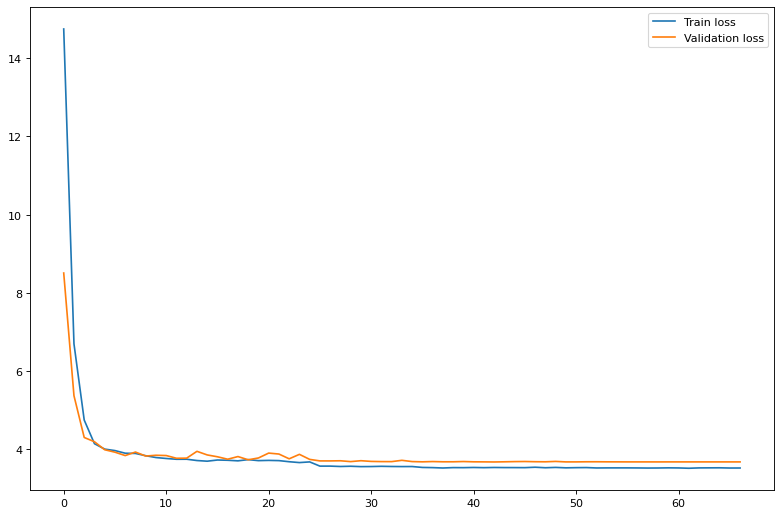

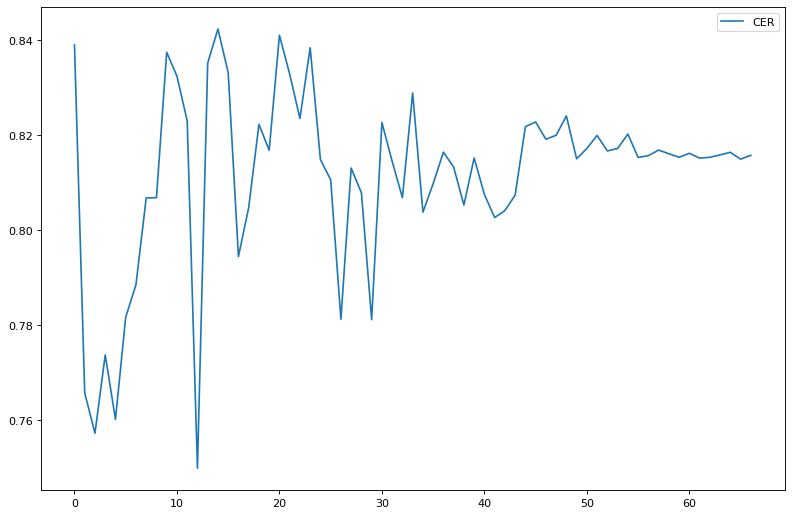

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")

# New Section